<a href="https://colab.research.google.com/github/tylee33/RL_Lecture/blob/master/%5BRL%EA%B0%95%EC%9D%98_4%5D_Mountain_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GYM 튜토리얼 & Model-Based 강화학습**

- 강화학습을 공부하기 위해 제공되는 환경 라이브러리로 GYM이 있습니다. 
- 해당 라이브러리를 사용하여 MountainCar문제를 풀어보겠습니다.

In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]

!pip install box2d-py
!pip install gym[Box_2D]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,281 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 1,281 kB in 1s (1,180 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd

  Created wheel for ez-setup: filename=ez_setup-0.9-py3-none-any.whl size=11013 sha256=fe65b9a4b239125611bf48b49d7b05278f095cc853fbadb902a8021a6198b396
  Stored in directory: /root/.cache/pip/wheels/f4/78/bd/f88c8eddfd5a8bf2a029e5cd8bc7a9914597002b081a000ffe
Successfully built ez-setup
     |████████████████████████████████| 448 kB 5.4 MB/s 


**강화학습 튜토리얼 (신경망 모델 사용)**

- 강화학습의 여러 방법론중에 기초적으로 먼저 신경망 모델을 사용하여 수행해보겠습니다. 
- 신경망 모델은 아래의 MountainCar라는 예제를 통해 진행하겠습니다.

**MountainCar**
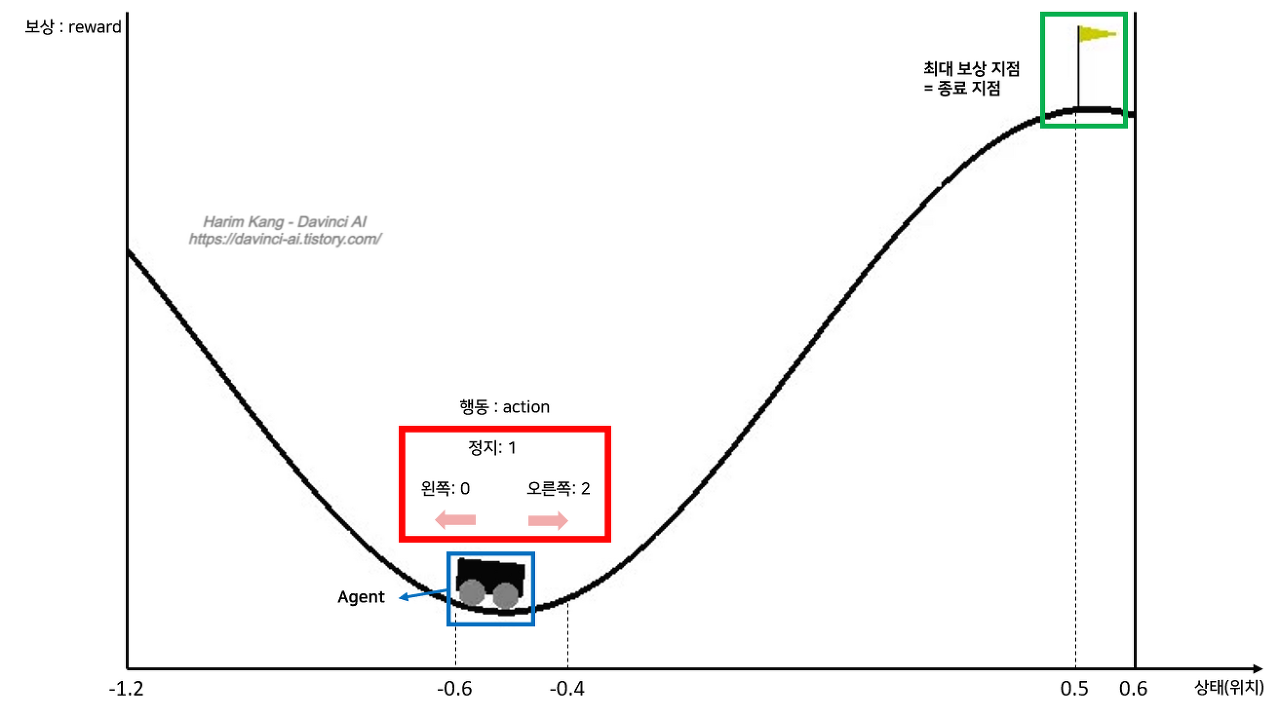

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import gym
import random

In [ ]:
# env.render() 함수의 결과를 mp4 동영상으로 보여주기 위한 코드
# from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
env = gym.make('MountainCar-v0')

**구성요소**

- Environment : 왼쪽과 오른쪽을 반복하여 가속도를 만들어야 언덕을 오를 수 있는 환경
- observation_space : Agent가 환경을 볼 수 있는 범위, 해당 공간에서만 정보를 얻을 수 있음
  - low : x축 좌표의 최소값과 최소 속도
  - high : x축 좌표의 최대값과 최대 속도
- action_space : Agent가 할 수 있는 행동의 경우의 수를 의미
  - Discrete는 이산적이라는 뜻. Discrete(3) '왼쪽'(0), '정지'(1), '오른쪽'(2) 총 3가지 행동 가능
- max_episode_steps : 각 에피소드마다의 종료 조건을 의미해당 값이 n이라면, 최대 n번의 time step을 가지고 n번 움직이면 종료된다는 것을 의미




In [ ]:
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space)
print(env._max_episode_steps)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
[-1.2  -0.07]
[0.6  0.07]
Discrete(3)
200


**기본적인 학습 코드**

- 변수 선언 및 env.reset()을 통하여 환경 초기화를 수행
- 아래와 같이 wrap_env로 기존 환경을 Monitor하도록 설정 후, show_video()를 통해서 확인 가능
- 반복문 안에서, sample()을 진행하고 랜덤한 action을 수행
  - '왼쪽'(0), '정지'(1), '오른쪽'(2) 세가지 경우 중에 하나가 랜덤으로 리턴됨
- 반복문 안에서, step을 진행.
  - env.step마다 action이 전달되어 Agent가 행동.
  - 리턴 값들은 각각 obs(환경이 바뀐 상태), reward(보상), done(에피소드 종료 여부), info(기타 정보들)이 전달됨
- 이때의 보상을 score에 더해서 step마다 score를 출력
- step시 마다 전달되는 done을 통하여 step이 모두 진행되었는지 또는 에피소드가 끝났는지를 파악
  - done이 True가 되면, 반복문을 벗어나고 최종 score와 step을 출력함
- env.close()를 통해 종료를 선언하고, show_video()함수를 통해 에피소드 실행 결과를 mp4파일로 화면에 출력

In [ ]:
env = wrap_env(env)
step = 0
score = 0
env.reset()

while True:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  score += reward
  step += 1
  if done:
    break
  
env.close()
show_video()
print('Final Score : ', score)
print('Step : ', step)

Final Score :  -200.0
Step :  200


**문제를 해결하는 코드**

- 위의 기본적인 학습 코드는 에피소드를 단순하게 랜덤적으로 수행함
- 아래의 코드에서는 신경망으로 학습하는 방법을 사용하려 한다.

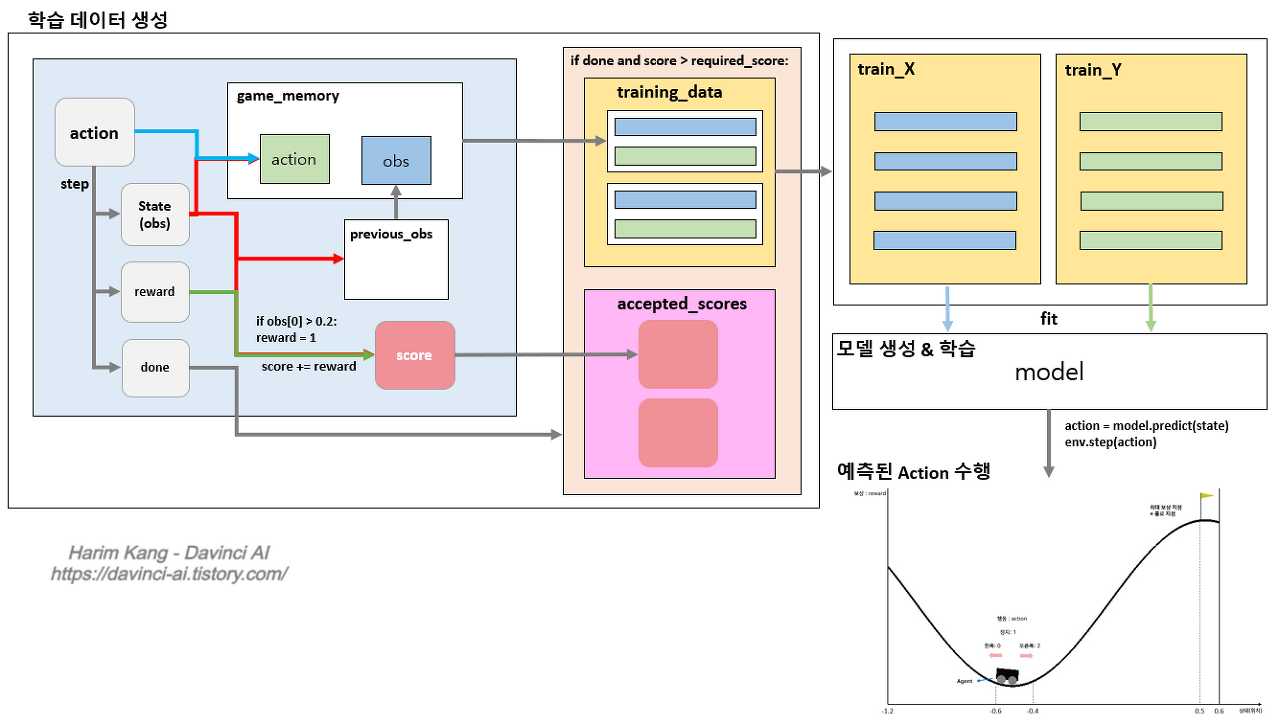

**세가지의 큰 순서로 진행**

- 학습 데이터 생성
- 모델 생성 및 학습
- 행동 예측 및 수행
## 1. 학습 데이터 생성
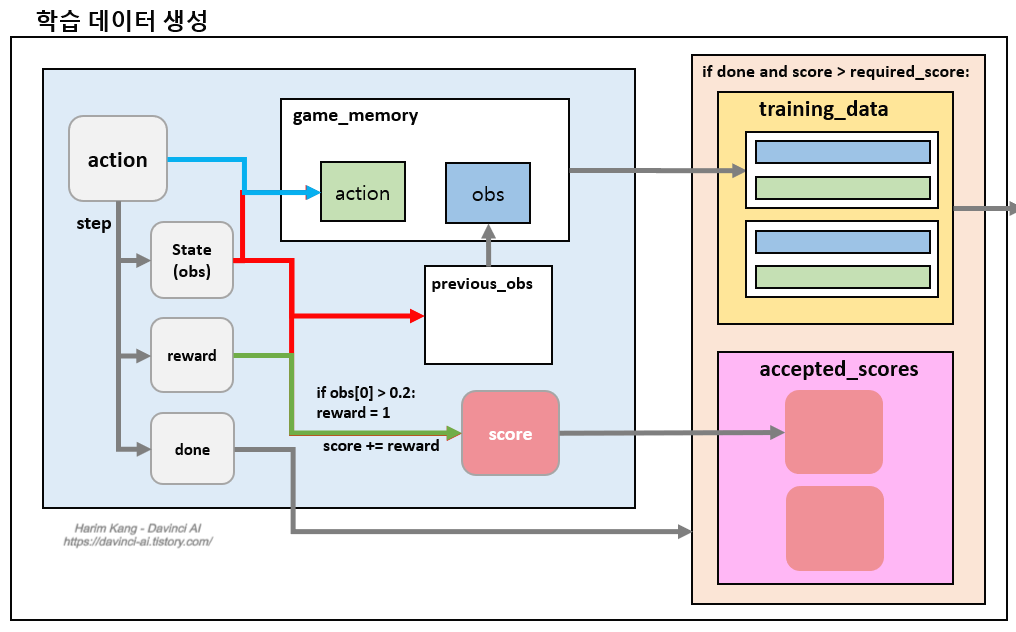

- 앞서 수행한 랜덤적인 방법을 반복적으로 수행하여 지정한 required_score보다 높은 점수를 얻은 행동들을 저장하는 방법으로 학습 데이터를 생성
- 한 시나리오의 score가 지정한 기준보다 높은 경우 game_memory에 저장해놓은 action들을 학습데이터로 쓰기 위하여 training_data에 저장함
- 20000번 반복하여 -198이상의 점수를 얻은 행동을 학습 데이터로 만듦

In [ ]:
import numpy as np

env = gym.make('MountainCar-v0')

scores = []
training_data = []
accepted_scores = []
required_score = -198
for i in range(20000):
  env.reset()
  score = 0
  game_memory = []
  previous_obs = []

  while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if len(previous_obs) > 0:
      game_memory.append([previous_obs, action])
    previous_obs = obs
    if obs[0] > -0.2:
      reward = 1
    score += reward
    if done:
      break
  
  scores.append(score)
  if score > required_score:
    accepted_scores.append(score)
    for data in game_memory:
      training_data.append(data)
print('finished!')

finished!


In [ ]:
print('mean of scores', np.mean(scores))
print('length of acceted_scores', len(accepted_scores))
print('mean of acceted_scores', np.mean(accepted_scores))

mean of scores -199.9208
length of acceted_scores 83
mean of acceted_scores -181.03614457831324


- 전체 경우에 대해서는 평균 -199점을 얻음. 기준 점수들은 100번 나왔고, 모아서 평균을 구하면 -180정도 나옴

## 2.모델 생성 및 학습
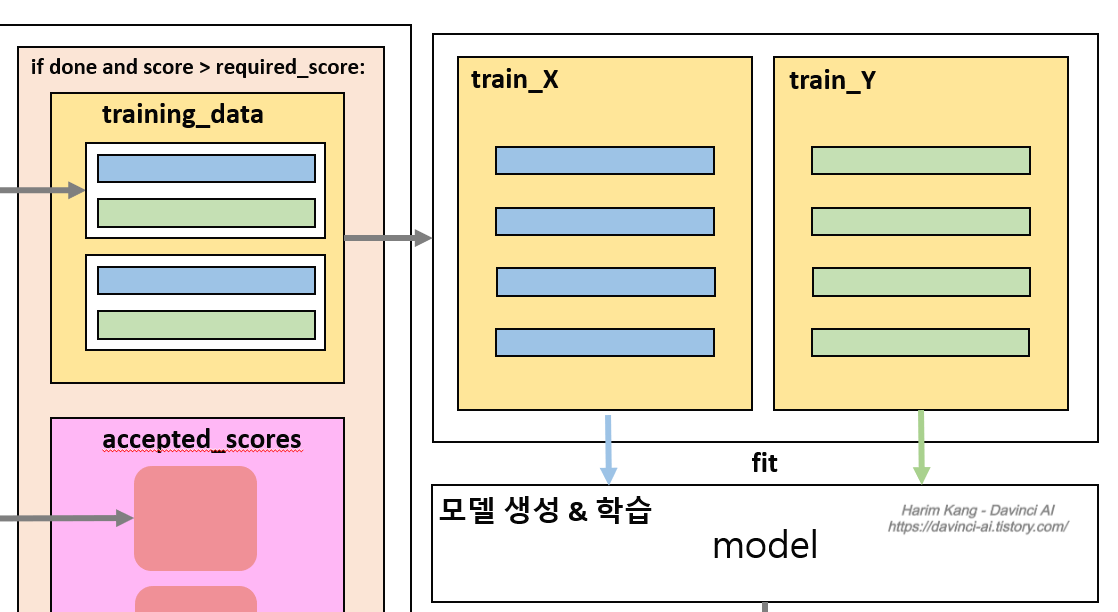

- 상태를 의미하는 obs를 train_x 데이터로, 그에 따른 행동(action)을 train_Y로 분리해줍니다.

In [ ]:
train_X = np.array([i[0] for i in training_data]).reshape(-1, 2)
train_Y = np.array([i[1] for i in training_data]).reshape(-1, 1)
print(train_X.shape)
print(train_Y.shape)

(16517, 2)
(16517, 1)


- model을 생성하여 학습을 시켜줍니다. 이때 모델은 action을 예측하는 모델임
  - 그러므로 -1,0,1로 이루어진 값을 예측하여야 한다. 이때, 분류(Classification)모델을 사용함
- Dense 레이어로 이루어진 Sequential모델을 선언해 줌
  - 마지막 층은 softmax를 통해서 action 3가지 중 하나를 예측하도록 선언해 줌
- Early Stopping을 사용하여 5번 이상 validation loss값이 상승하면 훈련을 멈추도록 함
- Overfitting 방지하기 위해, 데이터의 25%를 validation data로 사용

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_X, train_Y, epochs=30, callbacks=[callback], batch_size=16, validation_split=0.25)

Epoch 1/30
775/775 [==============================] - 6s 4ms/step - loss: 1.0988 - accuracy: 0.3500 - val_loss: 1.0975 - val_accuracy: 0.3504
Epoch 2/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0960 - accuracy: 0.3745 - val_loss: 1.0939 - val_accuracy: 0.3702
Epoch 3/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0900 - accuracy: 0.3919 - val_loss: 1.0881 - val_accuracy: 0.3949
Epoch 4/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0864 - accuracy: 0.4024 - val_loss: 1.0864 - val_accuracy: 0.3930
Epoch 5/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0857 - accuracy: 0.3999 - val_loss: 1.0841 - val_accuracy: 0.4007
Epoch 6/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0854 - accuracy: 0.4008 - val_loss: 1.0840 - val_accuracy: 0.3966
Epoch 7/30
775/775 [==============================] - 3s 4ms/step - loss: 1.0849 - accuracy: 0.4000 - val_loss: 1.0844 - val_accuracy: 0.4031
Epoch 

- 학습 결과 확인

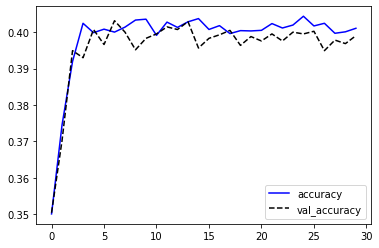

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.legend()
plt.show()

## 3. 행동 예측 및 수행
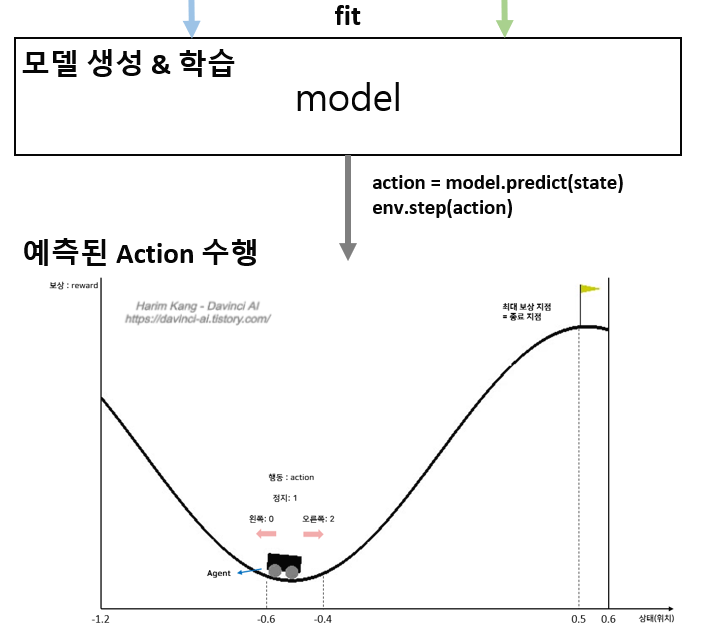
- 학습된 모델을 사용하여 다음 행동을 예측하여 시나리오를 수행

In [ ]:
env.close()
env = gym.make('MountainCar-v0')
scores = []
steps = []
actions = []

for i in range(500):
  score = 0
  step = 0
  previous_obs = []
  env.reset()

  while True:
    if len(previous_obs) == 0:
      action = env.action_space.sample()
      print('start! : ', i)
    else:
      logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
      action = np.argmax(logit)
      actions.append(action)
    obs, reward, done, _ = env.step(action)
    previous_obs = obs
    score += reward
    step += 1

    if done:
      break

  scores.append(score)
  steps.append(step)

print('finished!')

start! :  0
start! :  1
start! :  2
start! :  3
start! :  4
start! :  5
start! :  6
start! :  7
start! :  8
start! :  9
start! :  10
start! :  11
start! :  12
start! :  13
start! :  14
start! :  15
start! :  16
start! :  17
start! :  18
start! :  19
start! :  20
start! :  21
start! :  22
start! :  23
start! :  24
start! :  25
start! :  26
start! :  27
start! :  28
start! :  29
start! :  30
start! :  31
start! :  32
start! :  33
start! :  34
start! :  35
start! :  36
start! :  37
start! :  38
start! :  39
start! :  40
start! :  41
start! :  42
start! :  43
start! :  44
start! :  45
start! :  46
start! :  47
start! :  48
start! :  49
start! :  50
start! :  51
start! :  52
start! :  53
start! :  54
start! :  55
start! :  56
start! :  57
start! :  58
start! :  59
start! :  60
start! :  61
start! :  62
start! :  63
start! :  64
start! :  65
start! :  66
start! :  67
start! :  68
start! :  69
start! :  70
start! :  71
start! :  72
start! :  73
start! :  74
start! :  75
start! :  76
start! : 

- 시작은 랜덤 값으로 action을 받고, 그 이후에는 이전의 상태를 model에 예측하도록 값을 전달함.
  - 예측된 action을 사용하여 env.step을 이용하여 다음 순서를 수행함
- 이때의 점수와 스텝 수를 확인하면 아래와 같습니다.
  - model마다, 예측마다 결과는 다르게 나옵니다.

In [ ]:
print('mean of scores', np.mean(scores))
print('mean of steps', np.mean(steps))

mean of scores -133.876
mean of steps 133.876


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

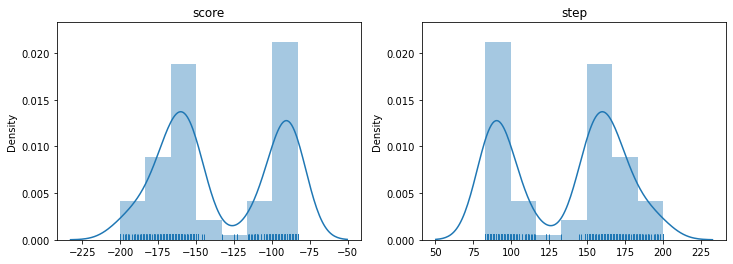

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('score')
ax[1].set_title('step')
sns.distplot(scores, rug=True, ax=ax[0])
sns.distplot(steps, rug=True, ax=ax[1])

In [ ]:
env.close()
env = wrap_env(gym.make('MountainCar-v0'))
env.reset()

score = 0
step = 0
previous_obs = []
while True:
  if len(previous_obs) == 0:
    action = env.action_space.sample()
  else:
    logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
    action = np.argmax(logit)
  obs, reward, done, _ = env.step(action)
  previous_obs = obs
  score += reward
  step += 1

  if done:
    break
  
print('score : ', score)
print('step : ', step)
env.close()
show_video()

score :  -178.0
step :  178
